In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime as dt
from functools import reduce

C:\Users\sanja\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#importing data
transaction = pd.read_excel("C:/Users/sanja/Desktop/my files/KPMG_VI_New_raw_data_update_final.xlsx", sheet_name='Transactions')
demo = pd.read_excel("C:/Users/sanja/Desktop/my files/KPMG_VI_New_raw_data_update_final.xlsx", sheet_name='CustomerDemographic')
Addr = pd.read_excel("C:/Users/sanja/Desktop/my files/KPMG_VI_New_raw_data_update_final.xlsx", sheet_name='CustomerAddress')

In [3]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             19640 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            19803 non-null  float64       
 12  product_first_sold_date  19803 n

In [4]:
trn= transaction[transaction['order_status'] == 'Approved'] 

In [5]:
# RFM Analysis

In [6]:
PRESENT = dt.datetime(2021,5,25)
# Calculate the number of days between present date and date of last purchase,total profit and frequency of 
# purchases of each customer
rfm= trn.groupby('customer_id').agg({'transaction_date': lambda date: (PRESENT - date.max()).days,
                                        'product_id': lambda num: num.count(),
                                        'standard_cost': lambda price: price.sum()})

In [7]:
rfm.columns=['recency','frequency','monetary']

In [8]:
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['1','2','3','4'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['4','3','2','1'])

In [9]:
#converting to string for concatenation
rfm['RFM_Score'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
customer_id,,,,,,,
1,1249,11,6066.36,1,1,1,111
2,1370,3,1922.81,4,4,4,444
3,1344,8,6525.42,4,1,1,411
4,1437,2,827.15,4,4,4,444
5,1258,6,3508.26,1,3,2,132


In [10]:
#filtering customers whose score is 333 and above; giving equal importance for recency, frequency and monetory value when
#considering top customers
top_customers =rfm[rfm['RFM_Score']>='333'].sort_values('monetary', ascending=False)

In [11]:
scores = top_customers[[ 'RFM_Score']].copy()
scores.head()

,RFM_Score
customer_id,
1932,411
1992,411
3320,411
34,411
2885,411


In [12]:
merged_data = pd.merge(scores,demo,on='customer_id')
merged_data.head()

,customer_id,RFM_Score,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure
0,1932,411,Sybila,Enefer,Female,98,1977-01-03,Librarian,Entertainment,Affluent Customer,N,<svg><script>0<1>alert('XSS')</script>,Yes,3.0
1,1992,411,Shanta,Attrill,Female,28,1995-10-21,Web Developer I,Manufacturing,Mass Customer,N,ZÌ®ÌÍÌ ÍÍAÌ¥ÌÌÍÌ»ÌLÌ£ÍÍÌ¯Ì¹ÌÍGÌ»OÌ­ÌÌ®,Yes,3.0
2,3320,411,Anabella,Mealham,Female,16,1994-06-02,Nuclear Power Engineer,Manufacturing,High Net Worth,N,1,No,6.0
3,2885,411,Minnie,Rolley,Female,70,1969-07-03,Compensation Analyst,Financial Services,Mass Customer,N,"""'",Yes,4.0
4,1946,411,Brannon,Gladman,Male,37,1959-01-04,Systems Administrator III,NaN,Mass Customer,N,âââ,No,8.0


In [13]:
# Datafarme that contains demographic and geographic location of top customers
final_df = pd.merge(merged_data,Addr,on='customer_id')

In [14]:
final_df.isna().sum()

customer_id                              0
RFM_Score                                0
first_name                               0
last_name                               45
gender                                   0
past_3_years_bike_related_purchases      0
DOB                                     23
job_title                              157
job_industry_category                  213
wealth_segment                           0
deceased_indicator                       0
default                                 88
owns_car                                 0
tenure                                  23
address                                  0
postcode                                 0
state                                    0
country                                  0
property_valuation                       0
dtype: int64

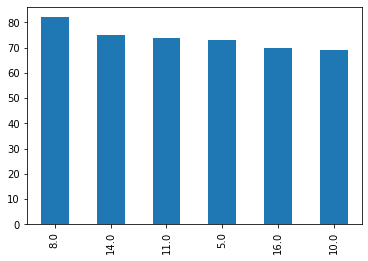

In [15]:
#Handling missing values
#Tenure
final_df.tenure.value_counts()[:10].plot(kind='bar')

In [16]:
avg= final_df['tenure'].mean()
final_df["tenure"].fillna(avg, inplace = True)

In [17]:
#Calculating Age from date of birth, filling missing values and creating bins
now = pd.Timestamp('now')
final_df['age'] = now - final_df['DOB']
final_df['age'] =final_df['age'].astype('timedelta64[Y]')

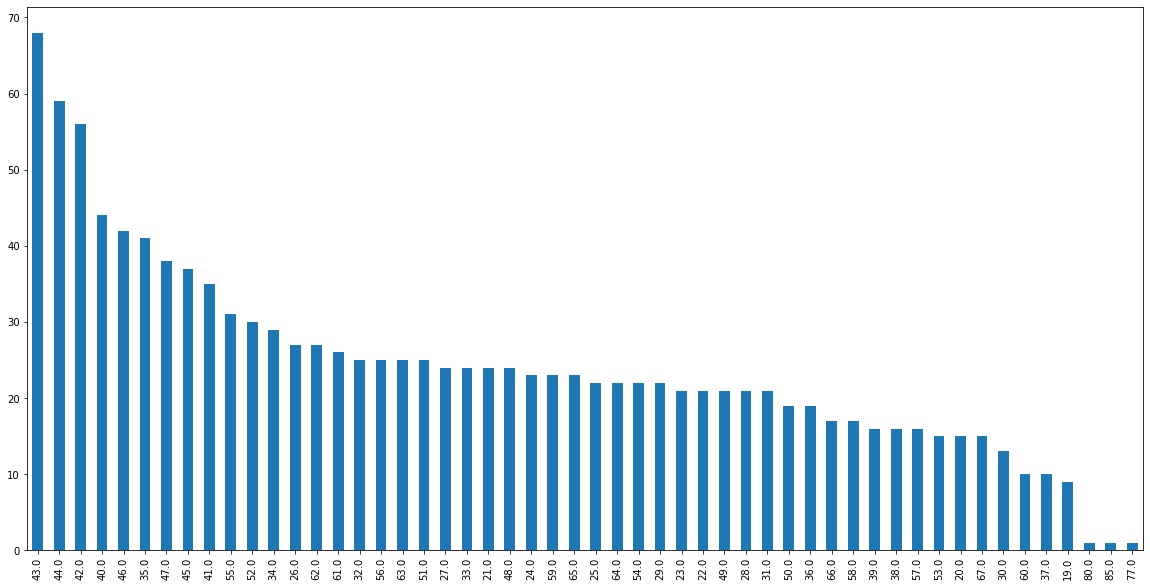

In [18]:
fig, ax = plt.subplots(figsize=(20,10))

final_df.age.value_counts().plot(kind='bar')

In [19]:
final_df['age_bins'] = pd.cut(x=final_df['age'], bins=[15, 25, 35, 45, 55, 67])

In [20]:
avg_age= final_df['age'].mean()
avg_age

43.246422893481714

In [21]:
final_df["age"].fillna(avg_age, inplace = True)

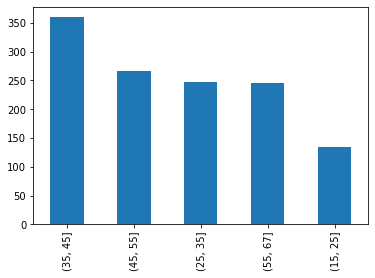

In [22]:
final_df.age_bins.value_counts().plot(kind='bar')

In [23]:
#gender
final_df = final_df.replace('Femal', 'Female')
final_df = final_df.replace('F', 'Female')
final_df = final_df.replace('Female', 'Female')
final_df = final_df.replace('Male', 'male')
final_df = final_df.replace('M', 'male')

In [24]:
final_df.gender.unique()

array(['Female', 'male', 'U'], dtype=object)

In [25]:
#cleaning and one hot encoding -states
final_df['state'].unique()

array(['VIC', 'NSW', 'Victoria', 'QLD', 'New South Wales'], dtype=object)

In [26]:
final_df = final_df.replace("VIC", "Victoria")
final_df = final_df.replace("New South Wales", "NSW")

In [27]:
final_df['state'].unique()

array(['Victoria', 'NSW', 'QLD'], dtype=object)

In [29]:
final_df

,customer_id,RFM_Score,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,...,default,owns_car,tenure,address,postcode,state,country,property_valuation,age,age_bins
0,1932,411,Sybila,Enefer,Female,98,1977-01-03,Librarian,Entertainment,Affluent Customer,...,<svg><script>0<1>alert('XSS')</script>,Yes,3.0,8318 Continental Alley,3175,Victoria,Australia,7,44.0,"(35, 45]"
1,1992,411,Shanta,Attrill,Female,28,1995-10-21,Web Developer I,Manufacturing,Mass Customer,...,ZÌ®ÌÍÌ ÍÍAÌ¥ÌÌÍÌ»ÌLÌ£ÍÍÌ¯Ì¹ÌÍGÌ»OÌ­ÌÌ®,Yes,3.0,726 Warrior Center,2077,NSW,Australia,10,25.0,"(15, 25]"
2,3320,411,Anabella,Mealham,Female,16,1994-06-02,Nuclear Power Engineer,Manufacturing,High Net Worth,...,1,No,6.0,88 Michigan Junction,3109,Victoria,Australia,10,27.0,"(25, 35]"
3,2885,411,Minnie,Rolley,Female,70,1969-07-03,Compensation Analyst,Financial Services,Mass Customer,...,"""'",Yes,4.0,17 Sachs Street,2761,NSW,Australia,8,51.0,"(45, 55]"
4,1946,411,Brannon,Gladman,male,37,1959-01-04,Systems Administrator III,NaN,Mass Customer,...,âââ,No,8.0,53 Dakota Court,2027,NSW,Australia,9,62.0,"(55, 67]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,431,444,Gale,Done,male,8,1956-03-26,Research Nurse,Health,Affluent Customer,...,ÅâÂ´Â®â Â¥Â¨ËÃ¸Ïââ,Yes,18.0,6920 Dwight Circle,4173,QLD,Australia,7,65.0,"(55, 67]"
1277,2271,444,King,Hoston,male,96,1974-03-26,NaN,Telecommunications,Mass Customer,...,"''''""",Yes,18.0,004 Gulseth Junction,2619,NSW,Australia,8,47.0,"(45, 55]"
1278,2532,444,Milli,Hubbert,Female,27,1969-05-01,NaN,Manufacturing,Mass Customer,...,ÌÌºÍÌ¹Ì¯ÍTÌ±Ì¤ÍÌ¥ÍÍhÍÌ²eÍÍÌ¼ÌÌÌ¼Ì£Í ÍÌÌ±Ì ÍÍÍN...,No,11.0,53723 Dunning Street,2153,NSW,Australia,11,52.0,"(45, 55]"
1279,3292,444,Hamlen,Slograve,male,71,1973-04-09,Web Designer I,Retail,Affluent Customer,...,() { 0; }; touch /tmp/blns.shellshock1.fail;,Yes,3.0,6 Golf Center,2042,NSW,Australia,10,48.0,"(45, 55]"
